<a href="https://colab.research.google.com/github/AdityaPunetha/TensorFlow-Fashion-MNIST-GAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [4]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ReLU
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt

%matplotlib inline

# Load Data

In [5]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4NJQMD/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4NJQMD/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
dataiterator = ds.as_numpy_iterator()

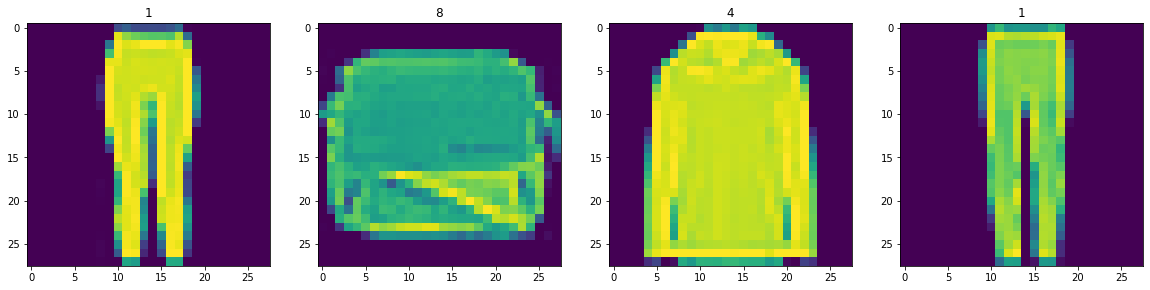

In [10]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [12]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [13]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [14]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Generator

In [17]:
latent_size = 128

In [18]:
generator = Sequential()
    
generator.add(Dense(7*7*128, input_dim=latent_size))
generator.add(ReLU())
generator.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
generator.add(UpSampling2D())
generator.add(Conv2D(128, 5, padding='same'))
generator.add(ReLU())
    
    # Upsampling block 2 
generator.add(UpSampling2D())
generator.add(Conv2D(128, 5, padding='same'))
generator.add(ReLU())
    
    # Convolutional block 1
generator.add(Conv2D(128, 4, padding='same'))
generator.add(ReLU())
    
    # Convolutional block 2
generator.add(Conv2D(128, 4, padding='same'))
generator.add(ReLU())
    
    # Conv layer to get to one channel
generator.add(Conv2D(1, 4, padding='same', activation='tanh'))

In [37]:
img = generator.predict(np.random.randn(1,128,1))

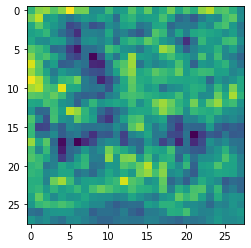

In [31]:
plt.imshow(np.squeeze(img[0]))

# Build Discriminator

In [40]:
discriminator = Sequential()
    
    # First Conv Block
discriminator.add(Conv2D(32, 5, input_shape = (28,28,1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
    
    # Second Conv Block
discriminator.add(Conv2D(64, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
    
    # Third Conv Block
discriminator.add(Conv2D(128, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
    
    # Fourth Conv Block
discriminator.add(Conv2D(256, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))

In [41]:
discriminator.predict(img)

array([[0.49950948]], dtype=float32)

# 